In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import time
from astropy import units as u
from scipy import stats
from dust_extinction.parameter_averages import F99
from __future__ import print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Measuring stellar parameters, extinction, and veiling

Notebook very much under construction; here are the major to-do items (updated 7/14):
    
* Use spectral indices to get a rough approximation of SpT -- **complete for late spty (7/14)**, though R5150 bug
* Measure veiling à la HH14 using the Ca I absorption features (where available) -- **in progress**
* Conduct a grid comparison with the Manara 2013 Xshooter library, adjusting extinction using a dust extinction toolkit (dust_extinction) and adding accretion continuum flux

## Spectral typing via indices

In [2]:
def spindexcalc(wv, fl, spindex, plot=False):
    """
    spindexcalc
    ----------
    
    Calculates optical spectral indices for pre-main sequence stars following the 
    methodology of Herczeg & Hillenbrand (2014). The input spectral wavelength coverage
    must match that of the requested spectral index, but is left generic as to be used 
    with any wavelength range/instrument.
    
    R5150:   Used to type range from K0-M0. Must be earlier than M0 but later than G, based 
             on the MgH band strength. Due to onset of Ti absorbing species in M-types, 
             this does not work beyond M0.5. RMS of 1.0 subclass.

    TiO6250: Used for types M0-M4, zeropoint of M0, RMS undefined
    
    TiO6800: Used for types K5 to M0.5, zeropoint of K0, RMS undefined
    
    TiO7140: Used for types M0-M4.5, zeropoint of M0, RMS of 0.1 if star between M1-M4, 
             RMS of 0.8 if earlier than M1. 
    
    TiO7700: Used for types M3-M8, zeropoint of M0, RMS of 0.21
    
    TiO8465: Used for types M4-M8, zeropoint of M0, RMS of 0.18
        
    Inputs
    ----------
    wv         : (array) input wavelength in nm
    fl         : (array) input flux in arbitrary units (as these are all ratios)
    spindex    : (string) requested spectral index. Can be of the following:
                            R5150, TiO6250, TiO6800, TiO7140, TiO7700, TiO8465 
    plot       : (boolean) whether to show a corresponding plot of spectra over indices used,
                            default = False
  
    Returns
    ----------
    indexval   : (float) index value
    spty       : (string) spectral type, as estimated from relations 
     
    Dependencies
    ----------
    scipy.stats.linregress
    """
    
    # K-type relevant spectral indices first
    
    if spindex == 'R5150':
        F_5100 = np.median(fl[(wv > 495.0) & (wv < 515.0)]) # 100 angstroms-wide
        F_4650 = np.median(fl[(wv > 460.0) & (wv < 470.0)]) 
        
        # perform a linear regression to fit the expect fluxes over this region - compensates for extinction
        y = np.concatenate([fl[(wv > 540.0) & (wv < 550.0)],fl[(wv > 460.0) & (wv < 470.0)]])
        x = np.concatenate([wv[(wv > 540.0) & (wv < 550.0)],wv[(wv > 460.0) & (wv < 470.0)]])
        slope, intercept, r_val, p_val, std_err = stats.linregress(x,y)
        
        Fline_4650 = np.median(slope*np.linspace(460,470,100) + intercept)
        Fline_5100 = np.median(slope*np.linspace(505,515,100) + intercept)
        R5150 = (F_5100/F_4650) * (Fline_4650/Fline_5100)
        
        # The following line is very hacky but seems to provide reasonable estimates?
        indexval = 1/R5150
        
        spty = 'K'+ str(np.round(-29.7 + 28.3*indexval,3))
                
        
    if spindex == 'TiO6800':
        cont = np.median(np.concatenate([fl[(wv > 660.0) & (wv < 666.0)], fl[(wv > 699.0) & (wv < 705.0)]]))
        band = np.median(fl[(wv > 675.0) & (wv < 690.0)])
        indexval = cont/band
        spty = 'K'+ str(np.round(-15.37 + 19.77*indexval,3))
        
        if plot == True:
            plt.figure(figsize = (10,7))
            plt.axvspan(660.0, 666.0, alpha=0.5, color='yellow', label='Cont.')
            plt.axvspan(699.0, 705.0, alpha=0.5, color='yellow')
            plt.axvspan(675.0, 690.0, alpha=0.5, color='cyan', label='Band')
            plt.plot(wv, fl, 'k', label='Data')
            plt.xlim(650,715)
            plt.ylim(0, 2*np.max([cont,band]))
            plt.legend(loc=1)
            plt.ylabel(r'Flux (erg cm$^{-2} \AA^{-1} s^{-1}$ )', size=14)
            plt.xlabel('Wavelength (nm)', size=14)
    
    # M-type relevant spectral indices
    
    if spindex == 'TiO6250':
        cont = np.median(fl[(wv > 643.0) & (wv < 646.5)])
        band = np.median(fl[(wv > 624.0) & (wv < 627.0)])
        indexval = np.log10((cont/band)-1.0)
        spty = 'M'+ str(np.round(3.20 - 5.43*indexval + 1.73*(indexval**2),3))
        
        if plot == True:
            plt.figure(figsize = (10,7))
            plt.axvspan(643.0, 646.5, alpha=0.5, color='yellow', label='Cont.')
            plt.axvspan(624.0, 627.0, alpha=0.5, color='cyan', label='Band')
            plt.plot(wv, fl, 'k', label='Data')
            plt.xlim(615,650)
            plt.ylim(0, 2*np.max([cont,band]))
            plt.legend(loc=1)
            plt.ylabel(r'Flux (erg cm$^{-2} \AA^{-1} s^{-1}$ )', size=14)
            plt.xlabel('Wavelength (nm)', size=14)        
        
    if spindex == 'TiO7140':
        cont = np.median(fl[(wv > 700.5) & (wv < 703.5)])
        band = np.median(fl[(wv > 713.0) & (wv < 715.5)])
        indexval = np.log10((cont/band)-1.0)
        spty = 'M'+ str(np.round(4.36 + 6.33*indexval + 1.57*(indexval**2),3))    
        
        if plot == True:
            plt.figure(figsize = (10,7))
            plt.axvspan(700.5, 703.5, alpha=0.5, color='yellow', label='Cont.')
            plt.axvspan(713.0, 715.5, alpha=0.5, color='cyan', label='Band')
            plt.plot(wv, fl, 'k', label='Data')
            plt.xlim(690,725)
            plt.ylim(0, 2*np.max([cont,band]))
            plt.legend(loc=1)
            plt.ylabel(r'Flux (erg cm$^{-2} \AA^{-1} s^{-1}$ )', size=14)
            plt.xlabel('Wavelength (nm)', size=14)            

    if spindex == 'TiO7700':
        print("Warning: The 8120-8160 Å range should only be used for continuum if corrected for telluric H2O.")
        cont = np.median(fl[(wv > 812.0) & (wv < 816.0)])
        band = np.median(fl[(wv > 775.0) & (wv < 780.0)])
        indexval = cont/band
        spty = 'M'+ str(np.round(0.11 + 2.27*indexval,3))    

        if plot == True:
            plt.figure(figsize = (10,7))
            plt.axvspan(812.0, 816.0, alpha=0.5, color='yellow', label='Cont.')
            plt.axvspan(775.0, 780.0, alpha=0.5, color='cyan', label='Band')
            plt.plot(wv, fl, 'k', label='Data')
            plt.xlim(765,825)
            plt.ylim(0, 2*np.max([cont,band]))
            plt.legend(loc=1)
            plt.ylabel(r'Flux (erg cm$^{-2} \AA^{-1} s^{-1}$ )', size=14)
            plt.xlabel('Wavelength (nm)', size=14)            
        
    if spindex == 'TiO8465':
        cont = np.median(fl[(wv > 834.5) & (wv < 838.5)])
        band = np.median(fl[(wv > 845.5) & (wv < 847.5)])
        indexval = cont/band
        spty = 'M'+ str(np.round(-0.74 + 4.21*indexval,3))  

        if plot == True:
            plt.figure(figsize = (10,7))
            plt.axvspan(834.5, 838.5, alpha=0.5, color='yellow', label='Cont.')
            plt.axvspan(845.5, 847.5, alpha=0.5, color='cyan', label='Band')
            plt.plot(wv, fl, 'k', label='Data')
            plt.xlim(825,855)
            plt.ylim(0, 2*np.max([cont,band]))
            plt.legend(loc=1)
            plt.ylabel(r'Flux (erg cm$^{-2} \AA^{-1} s^{-1}$ )', size=14)
            plt.xlabel('Wavelength (nm)', size=14)            
        
    return indexval, spty

## RECX1 Check - an earlier type t tauri

In [3]:
recx = fits.getdata('./RECX1/ADP.2017-06-02T22:54:12.076.fits')
hdr = fits.getheader('./RECX1/ADP.2017-06-02T22:54:12.076.fits')

In [4]:
fitstable = fits.open('./RECX1/ADP.2017-06-02T22:54:12.076.fits')[1].data
wv = fitstable[0][0]
fl = fitstable[0][1]
flerr = fitstable[0][2]

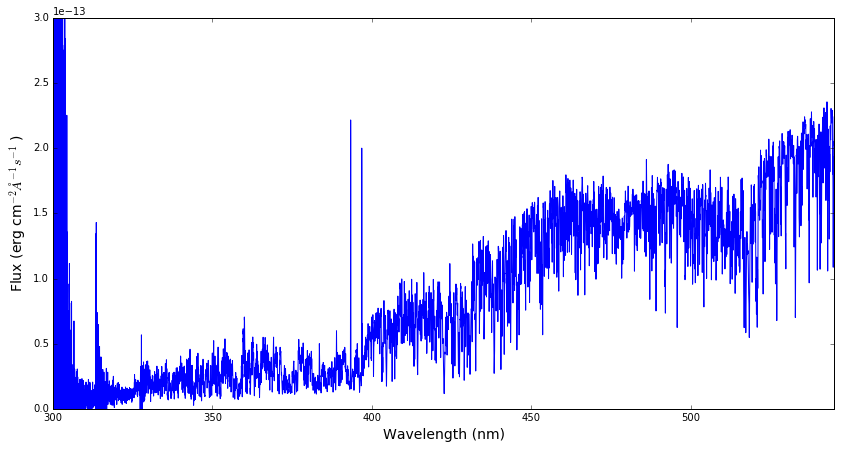

In [5]:
plt.figure(figsize=(14,7))
plt.plot(wv, fl)
plt.ylim(0,3e-13)
plt.xlim(300,545)
plt.ylabel(r'Flux (erg cm$^{-2} \AA^{-1} s^{-1}$ )', size=14)
plt.xlabel('Wavelength (nm)', size=14)

## Testing the R5150 spectral index first:

In [6]:
y = np.concatenate([fl[(wv > 540.0) & (wv < 550.0)],fl[(wv > 460.0) & (wv < 470.0)]])
x = np.concatenate([wv[(wv > 540.0) & (wv < 550.0)],wv[(wv > 460.0) & (wv < 470.0)]])

In [7]:
slope, intercept, r_val, p_val, std_err = stats.linregress(x,y)

In [8]:
slope

6.769473253971424e-16

In [9]:
F_5100 = np.median(fl[(wv > 505.0) & (wv < 515.0)]) # 100 angstroms-wide
F_4650 = np.median(fl[(wv > 460.0) & (wv < 470.0)]) 

# perform a linear regression to fit the expect fluxes over this region - compensates for extinction
y = np.concatenate([fl[(wv > 460.0) & (wv < 470.0)], fl[(wv > 540.0) & (wv < 550.0)]])
x = np.concatenate([wv[(wv > 460.0) & (wv < 470.0)], wv[(wv > 540.0) & (wv < 550.0)]])
slope, intercept, r_val, p_val, std_err = stats.linregress(x,y)

Fline_4650 = np.median(slope*np.linspace(460,470,100) + intercept)
Fline_5100 = np.median(slope*np.linspace(505,515,100) + intercept)

R5150 = (F_5100/F_4650) * (Fline_4650/Fline_5100)
R5150

0.7653918012992242

(8e-14, 2.4e-13)

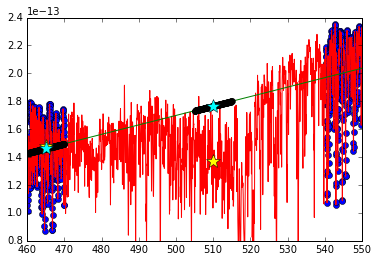

In [10]:
plt.plot(x,y,'o')
x_arr = np.linspace(460,550,1000)
plt.plot(wv, fl,'r')
plt.plot(x_arr, slope*x_arr + intercept)

plt.plot(np.linspace(505,515,100), slope*np.linspace(505,515,100) + intercept, 'ko')
plt.plot(np.linspace(460,470,100), slope*np.linspace(460,470,100) + intercept, 'ko')

plt.plot(510, F_5100, '*', c='yellow', ms=14)
plt.plot(465, F_4650, '*', c='yellow', ms=14)

plt.plot(510, Fline_5100, '*', c='cyan', ms=14)
plt.plot(465, Fline_4650, '*', c='cyan', ms=14)


plt.xlim(460,550)
plt.ylim(0.8e-13, 2.4e-13)

In [11]:
# convert to spectral type? if K0 = 0?
-29.7 + 28.3*(1/R5150) # only works if you invert R5150!! Need to fix

7.274527231624116

## Testing another spectral index: TiO6800

In [12]:
recx_opt = fits.getdata('./RECX1/ADP.2017-06-02T22:54:12.499.fits')
fitstable_opt = fits.open('./RECX1/ADP.2017-06-02T22:54:12.499.fits')[1].data
wv_opt = fitstable_opt[0][0]
fl_opt = fitstable_opt[0][1]
flerr_opt = fitstable_opt[0][2]

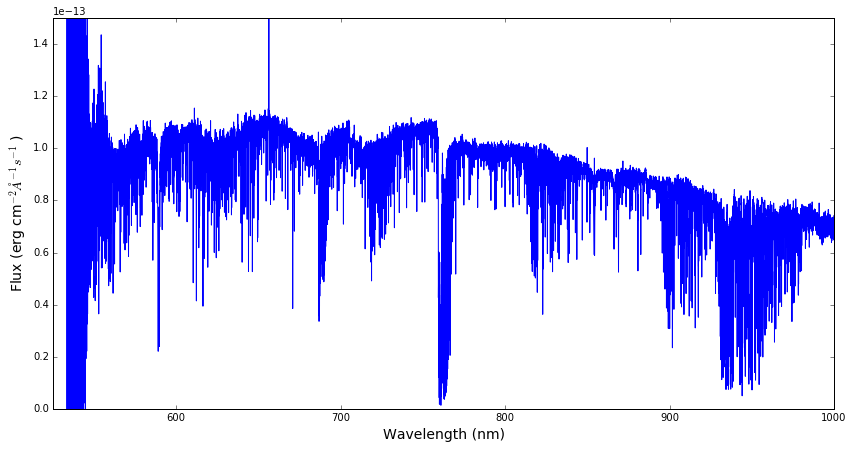

In [13]:
plt.figure(figsize=(14,7))
plt.plot(wv_opt, fl_opt)
plt.ylim(0,1.5e-13)
plt.xlim(525,1000)
plt.ylabel(r'Flux (erg cm$^{-2} \AA^{-1} s^{-1}$ )', size=14)
plt.xlabel('Wavelength (nm)', size=14)

In [14]:
cont = np.median(np.concatenate([fl_opt[(wv_opt > 660.0) & (wv_opt < 666.0)], fl_opt[(wv_opt > 699.0) & (wv_opt < 705.0)]]))
band = np.median(fl_opt[(wv_opt > 675.0) & (wv_opt < 690.0)])

In [15]:
x = cont/band
x

1.0667873140378648

In [16]:
-15.37 + 19.77*x

5.720385198528588

In [17]:
# For zeropoint of K0, this is K5.7 which is pretty close

(1.0667873140378648, 'K5.72')

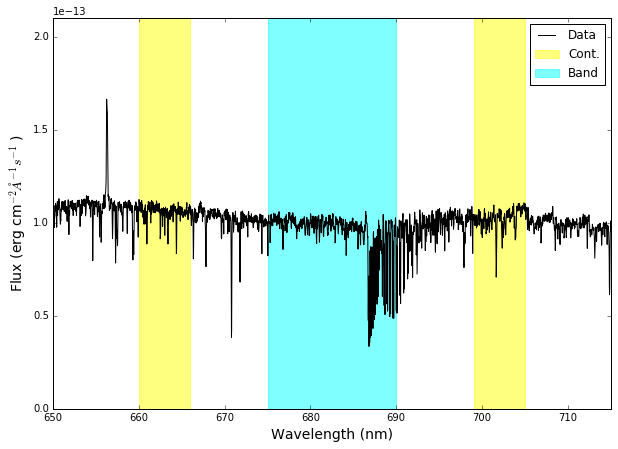

In [18]:
spindexcalc(wv_opt, fl_opt, 'TiO6800', plot=True)

In [19]:
spindexcalc(wv, fl, 'R5150')

(1.2661816401615762, 'K6.133')

## RECX5 Test (later SpTy)

In [20]:
r5_nirdata = fits.getdata('./RECX5/ADP.2017-06-02T21:53:09.689.fits')
wv_nir = r5_nirdata[0][0]
fl_nir = r5_nirdata[0][1]

In [21]:
r5_optdata = fits.getdata('./RECX5/ADP.2017-06-02T21:53:10.117.fits')
wv_opt = r5_optdata[0][0]
fl_opt = r5_optdata[0][1]

In [22]:
r5_uvdata = fits.getdata('./RECX5/ADP.2017-06-02T21:53:10.363.fits')
wv_uv = r5_uvdata[0][0]
fl_uv = r5_uvdata[0][1]

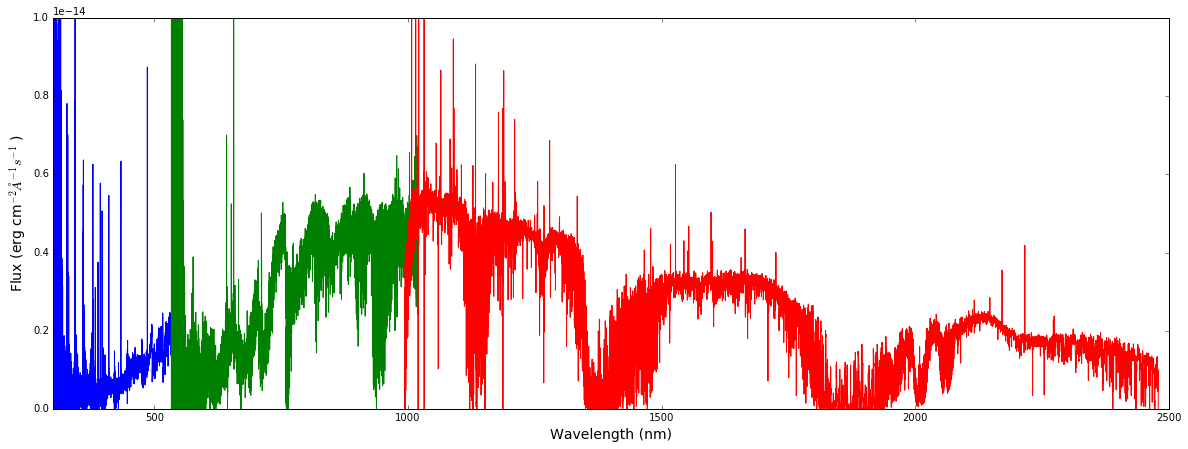

In [23]:
plt.figure(figsize=(20,7))
plt.plot(wv_uv, fl_uv)
plt.plot(wv_opt, fl_opt)
plt.plot(wv_nir, fl_nir)
plt.ylim(0,1e-14)
plt.xlim(300,2500)
plt.ylabel(r'Flux (erg cm$^{-2} \AA^{-1} s^{-1}$ )', size=14)
plt.xlabel('Wavelength (nm)', size=14)

In [24]:
spindexcalc(wv_opt, fl_opt, 'TiO7140')

(0.007065672158310126, 'M4.405')

In [25]:
spindexcalc(wv_opt, fl_opt, 'TiO8465')

(1.1823821848246503, 'M4.238')

## Spectral typing our object:

In [26]:
optdata = np.loadtxt('../../RV/xshooter_oct_medvis.txt', skiprows=1)
wv_v = optdata[:,0]
fl_v = optdata[:,1]

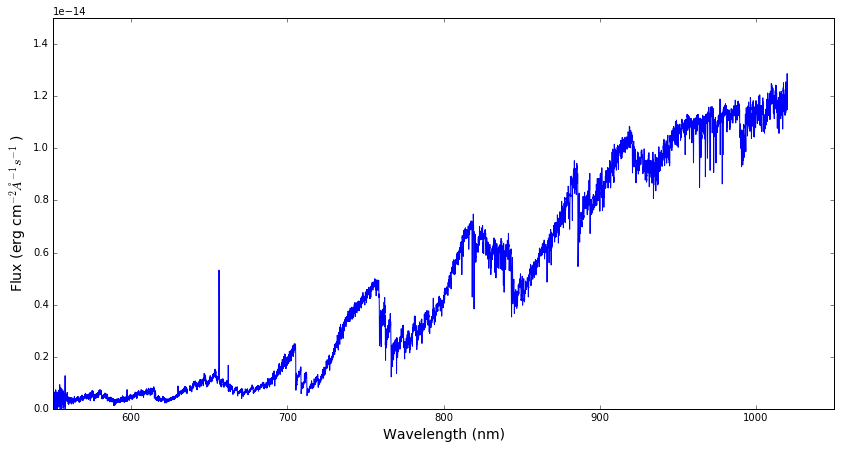

In [27]:
plt.figure(figsize=(14,7))
plt.plot(wv_v, fl_v)
plt.ylim(0,1.5e-14)
plt.xlim(550,1050)
plt.ylabel(r'Flux (erg cm$^{-2} \AA^{-1} s^{-1}$ )', size=14)
plt.xlabel('Wavelength (nm)', size=14)

(0.24075310225927768, 'M1.993')

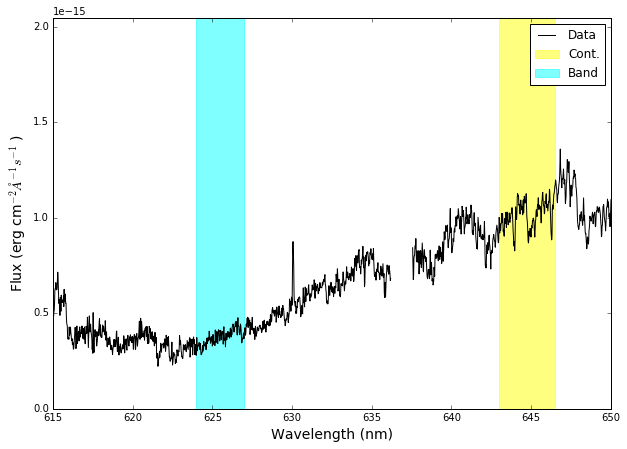

In [28]:
spindexcalc(wv_v, fl_v, 'TiO6250', plot=True)

(0.17989669298682975, 'M5.55')

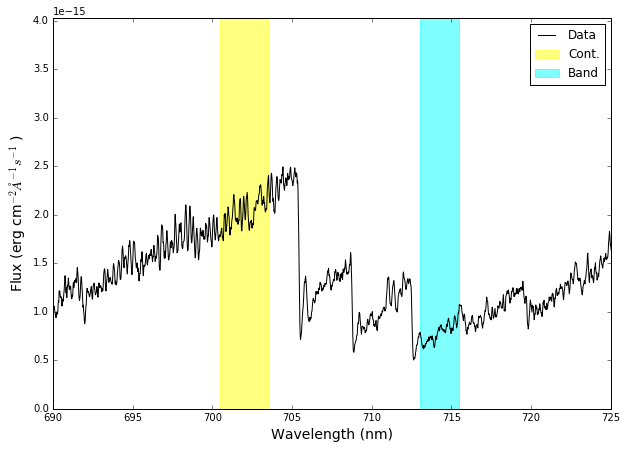

In [29]:
spindexcalc(wv_v, fl_v, 'TiO7140', plot=True)

(2.5886241355474335, 'M5.986')

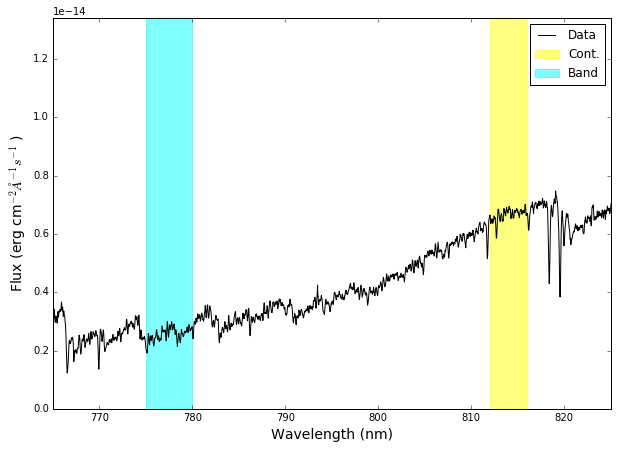

In [30]:
spindexcalc(wv_v, fl_v, 'TiO7700', plot=True)

(1.4137128161542787, 'M5.212')

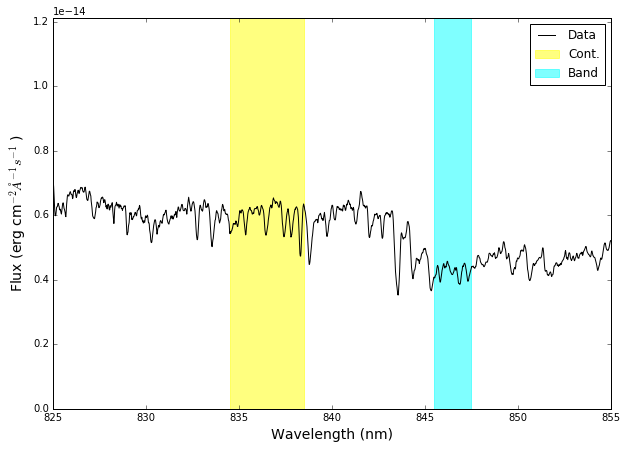

In [31]:
spindexcalc(wv_v, fl_v, 'TiO8465', plot=True)

### Repeating process for the December data

In [32]:
optdata = np.loadtxt('../../RV/xshooter_dec_medvis.txt', skiprows=1)
wv_v = optdata[:,0]
fl_v = optdata[:,1]

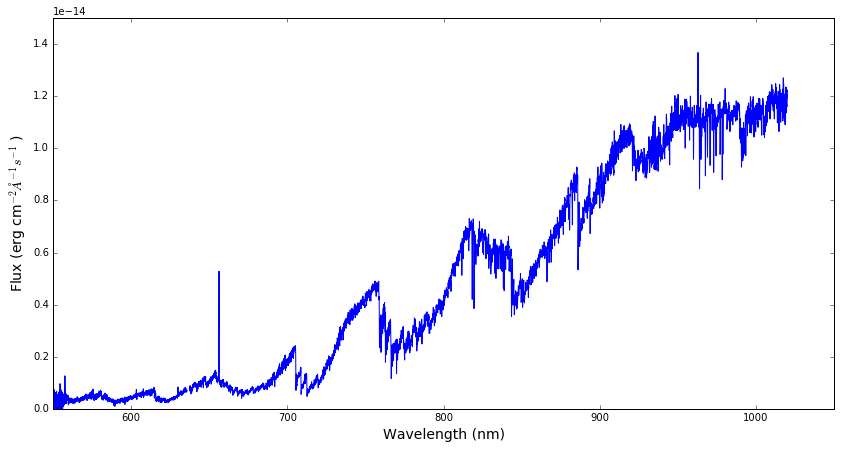

In [33]:
plt.figure(figsize=(14,7))
plt.plot(wv_v, fl_v)
plt.ylim(0,1.5e-14)
plt.xlim(550,1050)
plt.ylabel(r'Flux (erg cm$^{-2} \AA^{-1} s^{-1}$ )', size=14)
plt.xlabel('Wavelength (nm)', size=14)

(0.23358926888849568, 'M2.026')

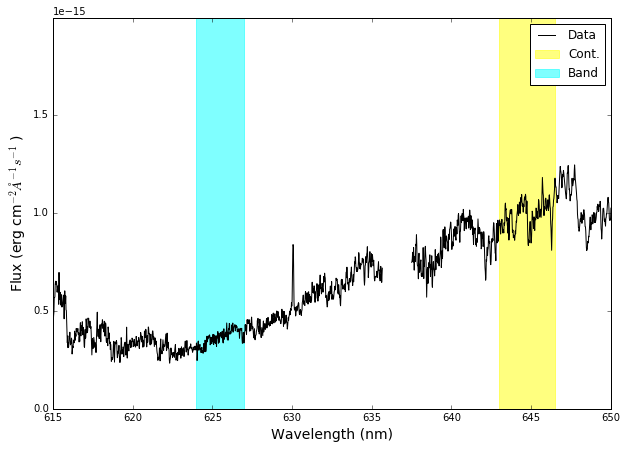

In [34]:
spindexcalc(wv_v, fl_v, 'TiO6250', plot=True)

(0.18893444067580054, 'M5.612')

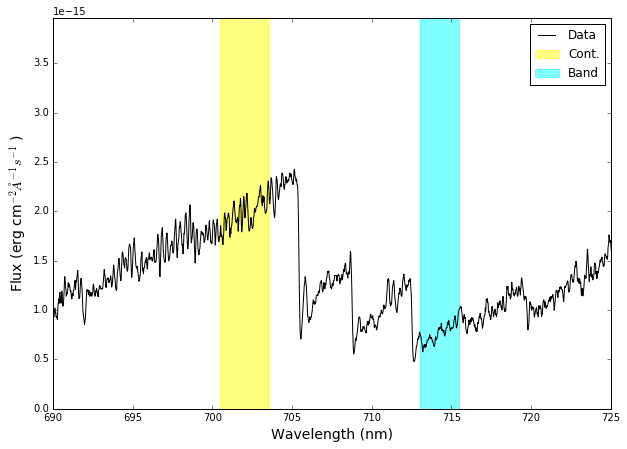

In [35]:
spindexcalc(wv_v, fl_v, 'TiO7140', plot=True)

(2.614668056709431, 'M6.045')

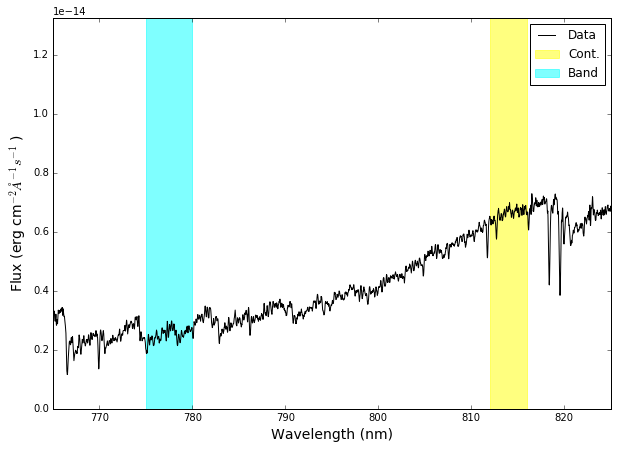

In [36]:
spindexcalc(wv_v, fl_v, 'TiO7700', plot=True)

(1.4244293871666407, 'M5.257')

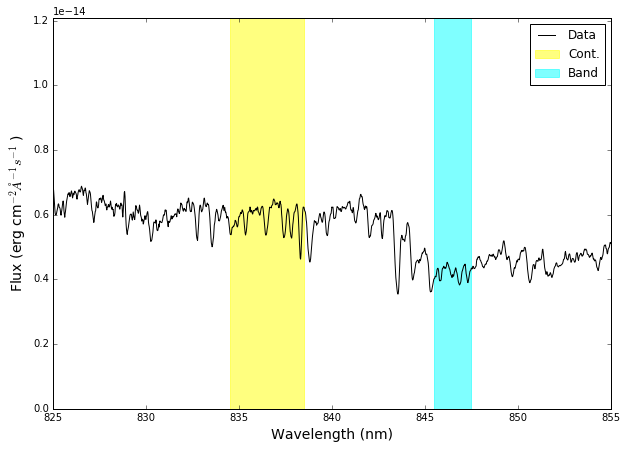

In [37]:
spindexcalc(wv_v, fl_v, 'TiO8465', plot=True)

## Extinction treatment:

In [ ]:
ext = F99(Rv=3.1) 
spectrum_noext = fxout*ext.extinguish(wavelength_object*u.nm, Av=2.7)